In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import joblib
import warnings
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from itertools import chain
from collections import Counter
from pprint import pprint
#!pip install wordcloud
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install scikit-multilearn

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('vader_lexicon')
spacy.load('en_core_web_sm')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             hamming_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from skmultilearn.model_selection import IterativeStratification


#!pip install pyldavis
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()

sns.set(font_scale=1.3)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gayad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gayad\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
train = pd.read_csv('../Data/lab4_train.csv') 

In [3]:
train.head()

,id,text,aspectCategory,polarity
0,3121,But the staff was so horrible to us.,service,negative
1,2777,"To be completely fair, the only redeeming fact...",food,positive
2,2777,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative
3,1634,"The food is uniformly exceptional, with a very...",food,positive
4,2534,Where Gabriela personaly greets you and recomm...,service,positive


In [4]:
train.columns

Index(['id', 'text', 'aspectCategory', 'polarity'], dtype='object')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3156 entries, 0 to 3155
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3156 non-null   int64 
 1   text            3156 non-null   object
 2   aspectCategory  3156 non-null   object
 3   polarity        3156 non-null   object
dtypes: int64(1), object(3)
memory usage: 98.8+ KB


In [6]:
# Print unique values of 'aspectCategory'
unique_aspect_categories = train['aspectCategory'].unique()
print("Unique aspect categories:", unique_aspect_categories)

Unique aspect categories: ['service' 'food' 'anecdotes/miscellaneous' 'price' 'ambience']


In [7]:
print(train['polarity'].unique())
print(train['polarity'].dtype)

['negative' 'positive' 'neutral' 'conflict']
object


In [8]:
# Drop rows with 'conflict' polarity
train = train[train['polarity'] != 'conflict']

train.head()

,id,text,aspectCategory,polarity
0,3121,But the staff was so horrible to us.,service,negative
1,2777,"To be completely fair, the only redeeming fact...",food,positive
2,2777,"To be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative
3,1634,"The food is uniformly exceptional, with a very...",food,positive
4,2534,Where Gabriela personaly greets you and recomm...,service,positive


In [9]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'polarity' column
train['polarity'] = label_encoder.fit_transform(train['polarity'])

# Print the mapping between original labels and encoded numerical labels
print("Mapping of original labels to numerical labels:")
for label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{label}: {encoded_label}")

Mapping of original labels to numerical labels:
negative: 0
neutral: 1
positive: 2


In [10]:
print(train['polarity'].unique())
print(train['polarity'].dtype)

[0 2 1]
int32


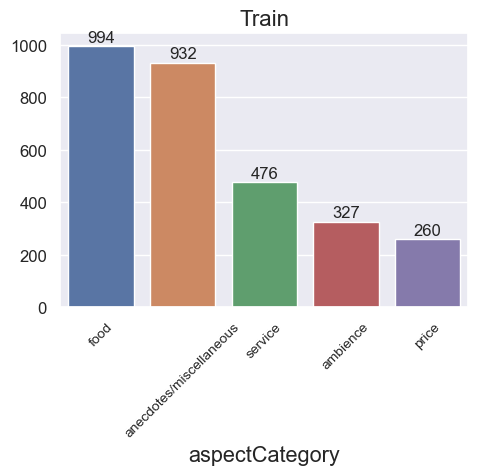

In [11]:
def aspects_dis_plot(train, fig, plot_index):
    # Number of samples for each aspect
    df = train['aspectCategory'].value_counts()

    ax = fig.add_subplot(2, 4, plot_index)
    sns.barplot(x=df.index, y=df.values, ax=ax)

    for rect, label in zip(ax.patches, df.values):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', 
                va='bottom', fontsize=12)  # Adjust font size for label text

    ax.tick_params(axis='x', labelsize=10, rotation=45)  # Set smaller font size and rotate x-axis labels
    ax.tick_params(axis='y', labelsize=12)  # Set font size for y-axis labels
    return ax

# Set the size of the figure
fig = plt.figure(figsize=(18, 8))

# Call the function to create the plot
ax1 = aspects_dis_plot(train, fig, 1)
ax1.set_title('Train', fontsize=16)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

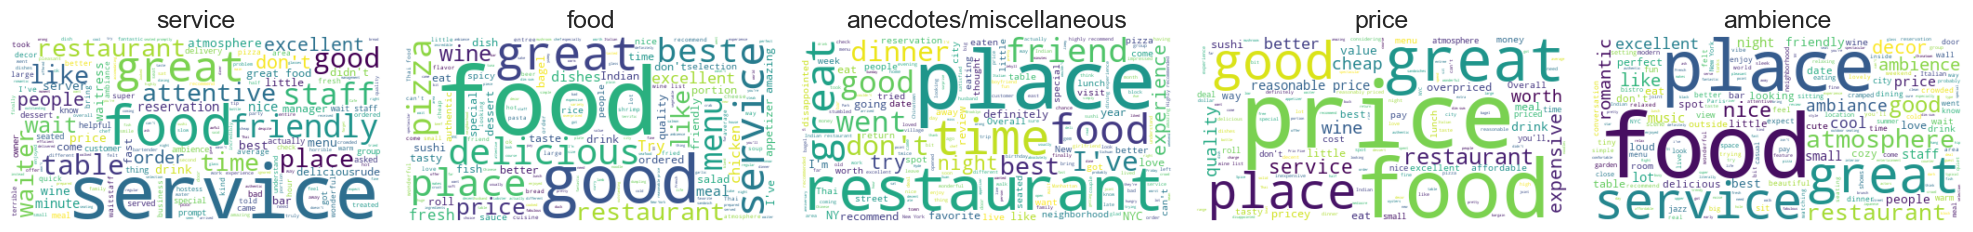

In [12]:
def create_wordclouds(train):
    unique_aspect_categories = train['aspectCategory'].unique()
    num_aspect_categories = len(unique_aspect_categories)

    fig, axes = plt.subplots(1, num_aspect_categories, figsize=(20, 6))  # Adjust the figure size as needed

    for i, aspect_category in enumerate(unique_aspect_categories):
        subset = train[train['aspectCategory'] == aspect_category]
        wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white').generate(" ".join(subset['text']))
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(aspect_category, fontsize=18)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the data DataFrame
create_wordclouds(train)

In [13]:
def preprocess_text(text):
    '''Preprocess a text for LDA topic modeling'''
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    tokens_lem = [WordNetLemmatizer().lemmatize(token, pos='v') for token in tokens]
    processed = [token for token in tokens_lem if len(token) > 3]
    return processed


def get_main_topic(processed_text, model, topics_names):
    ''' Predict the dominant topic in a text using LDA'''
    bow_vector = model.id2word.doc2bow(processed_text)
    topics_scores = model[bow_vector]
    dominant_topic, _ = sorted(topics_scores, 
                               key=lambda tup: tup[1], 
                               reverse=True)[0]
    return topics_names[dominant_topic]


def get_sentiment(text):
    '''return the sentiment. ouput: positive/negative/neutral'''
    scores = sia.polarity_scores(text)
    if scores['compound'] > 0:
        return 'positive'
    elif scores['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

In [14]:
# create SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()

# load the nlp model for POS and dependency tagging
nlp = spacy.load("en_core_web_sm")

# Define mapping between aspects or topics and their indices
aspects = ['service', 'food', 'anecdotes/miscellaneous', 'price', 'ambience']

ldaTopic_to_aspect = {
    0: ['service'],
    1: ['food'],
    2: ['anecdotes/miscellaneous'],
    3: ['price'],
    4: ['ambience']
}

In [15]:
# Preprocess reviews for LDA
reviews_processed = [preprocess_text(text) for text in train['text']]
# Create dictionary and corpus
dictionary = corpora.Dictionary(reviews_processed)
# convert tokenized documents into a bag of words corpus
corpus_bow = [dictionary.doc2bow(text) for text in reviews_processed]
# Using TF-IDF 
tfidf = models.TfidfModel(corpus_bow) 
corpus_tfidf = tfidf[corpus_bow]

ldamodel = models.ldamodel.LdaModel(corpus_bow, num_topics=5,
                                    id2word=dictionary, passes=10, 
                                    random_state=12)
pprint(ldamodel.print_topics())

[(0,
  '0.049*"food" + 0.040*"great" + 0.036*"price" + 0.025*"service" + '
  '0.021*"place" + 0.015*"atmosphere" + 0.015*"wine" + 0.011*"good" + '
  '0.010*"love" + 0.009*"little"'),
 (1,
  '0.017*"dinner" + 0.016*"like" + 0.015*"place" + 0.013*"good" + '
  '0.011*"restaurant" + 0.010*"food" + 0.010*"drink" + 0.009*"best" + '
  '0.009*"seat" + 0.008*"order"'),
 (2,
  '0.051*"food" + 0.042*"service" + 0.014*"wait" + 0.013*"staff" + '
  '0.012*"time" + 0.012*"indian" + 0.012*"restaurant" + 0.011*"friendly" + '
  '0.010*"place" + 0.010*"restaurants"'),
 (3,
  '0.029*"place" + 0.028*"good" + 0.022*"recommend" + 0.022*"great" + '
  '0.019*"food" + 0.012*"sushi" + 0.011*"fish" + 0.011*"service" + '
  '0.010*"highly" + 0.010*"pizza"'),
 (4,
  '0.017*"restaurant" + 0.016*"menu" + 0.014*"experience" + 0.013*"food" + '
  '0.011*"best" + 0.010*"place" + 0.010*"enjoy" + 0.009*"good" + '
  '0.009*"definitely" + 0.008*"like"')]


In [16]:
# Visualization
gensim_models.prepare(ldamodel, corpus_bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.095110 -0.094588       1        1  21.815211
2      0.141801  0.127037       2        1  20.971274
4     -0.105501  0.124356       3        1  20.545737
3      0.027057 -0.111828       4        1  18.414322
1     -0.158467 -0.044978       5        1  18.253456, topic_info=          Term        Freq       Total Category  logprob  loglift
164      price  179.000000  179.000000  Default  30.0000  30.0000
26       great  268.000000  268.000000  Default  29.0000  29.0000
146    service  303.000000  303.000000  Default  28.0000  28.0000
23   recommend   74.000000   74.000000  Default  27.0000  27.0000
262     dinner   55.000000   55.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
99        time   17.707709  116.753024   Topic5  -5.2174  -0.1852
214  delicious   16.770681   89.977173   Topic5  -5.2718   0.0209
188       come   16.420773   83.665589   Topic5  -5.2929   0.0725
136     people   14.911967   55.803590   Topic5  -5.3892   0.3811
216  excellent   14.208115   90.932480   Topic5  -5.4376  -0.1555

[341 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
680       1  0.678822   actually
680       5  0.285820   actually
269       4  0.169989      after
269       5  0.793283      after
1681      1  0.941075      allow
...     ...       ...        ...
483       5  0.066008  wonderful
357       4  0.826110    workers
1981      1  0.932134      worse
194       1  0.264936      worth
194       4  0.715327      worth

[513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2])

In [17]:
# extract topics probabilities for each review 
def get_topics_scores(corpus, doc_index, ldamodel):
    '''get the scores associated with all topics for a single review'''
    _, scores = list(zip(*ldamodel.get_document_topics(corpus[doc_index], 
                                                       minimum_probability=0.0)))
    return list(scores)

# organize the results (topics probabilities) for all reviews in a data frame
reviews_topics = [get_topics_scores(corpus_bow, doc_index, ldamodel) 
                  for doc_index in range(len(reviews_processed))]
reviews_topics = pd.DataFrame(reviews_topics)
reviews_topics.columns = ['lda_topic' + str(col) 
                          for col in reviews_topics.columns]
print(reviews_topics.shape)
reviews_topics.head()

(2989, 5)


,lda_topic0,lda_topic1,lda_topic2,lda_topic3,lda_topic4
0,0.068708,0.066800,0.730018,0.067101,0.067373
1,0.020753,0.918299,0.020482,0.020278,0.020189
2,0.020747,0.918304,0.020482,0.020278,0.020189
3,0.018393,0.018334,0.018970,0.018463,0.925841
4,0.033355,0.033531,0.033355,0.866404,0.033356


In [18]:
# Define a function to split text into phrases
def split_text_into_phrases(text):
    '''Split the text into phrases'''
    phrases = [txt.strip() for txt in text.split('.') if len(txt) > 0]
    return phrases

# Apply the function to each review in the dataset
phrases_per_review = [split_text_into_phrases(review) for review in train['text']]

# Display the phrases for the first few reviews
for idx, phrases in enumerate(phrases_per_review[:5]):
    print(f"Review {idx + 1} phrases:")
    print(phrases)
    print()

Review 1 phrases:
['But the staff was so horrible to us']

Review 2 phrases:
["To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora"]

Review 3 phrases:
["To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora"]

Review 4 phrases:
["The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not"]

Review 5 phrases:
['Where Gabriela personaly greets you and recommends you what to eat']



In [19]:
# Apply the function to each row in the dataset column
for idx, phrase in enumerate(phrases):
    if idx >= 5:
        break  # Stop after processing the first 5 rows
    
    # Text processing
    preprocessed_lda = preprocess_text(phrase)
    
    # Identify aspects using LDA
    topics_full = []
    topics = get_main_topic(preprocessed_lda, ldamodel, ldaTopic_to_aspect)
    if len(topics) == 0:
        topics = ['miscellaneous']
    topics_full.extend(topics)
    
    # Select topic with highest vote
    counts = Counter(topics_full)
    main_topics = [topic for (topic, count) in counts.items() 
                   if counts[topic] == max(counts.values())]
    
    # Output
    print(f"Review {idx + 1} phrase:")
    print(phrase)
    print(f'Main topics: {main_topics}\n')


Review 1 phrase:
Where Gabriela personaly greets you and recommends you what to eat
Main topics: ['price']



In [20]:
# Define LDA model
ldamodel = models.ldamodel.LdaModel(corpus_bow, num_topics=5,
                                    id2word=dictionary, passes=10, 
                                    random_state=12)

# Loop through phrases in the first five rows
for review_phrases in phrases_per_review[:5]:
    for phrase in review_phrases:
        # Text processing
        preprocessed = preprocess_text(phrase)
        preprocessed_lda = preprocess_text(phrase)
        
        # Identify aspects using LDA
        topics_full = []

        # LDA
        topics = get_main_topic(preprocessed_lda, ldamodel, ldaTopic_to_aspect)
        if len(topics) == 0:
            topics = ['miscellaneous']
        topics_full.extend(topics)
        
        # Select topic with highest vote
        counts = Counter(topics_full)
        main_topics = [topic for (topic, count) in counts.items() 
                       if counts[topic] == max(counts.values())]
        
        # Output
        print(phrase)
        print(f'main topics: {main_topics}\n')




But the staff was so horrible to us
main topics: ['anecdotes/miscellaneous']

To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora
main topics: ['food']

To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora
main topics: ['food']

The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not
main topics: ['ambience']

Where Gabriela personaly greets you and recommends you what to eat
main topics: ['price']



In [21]:
def get_descriptors(text):
    '''get adjectives for a subject/noun'''

    def is_adjective(token):
        '''return whether or not a token is an adjective.'''
        return token.dep_ == 'amod' or token.pos_ == 'ADJ'

    def get_children(token):
        '''get a list reprsenting all adjectives that are either first 
        or second order children of a given token.'''
        first_ch = [child for child in token.children
                    if child.pos_ not in ['AUX', 'VERB']]
        second_ch = [list(ch.children) for ch in first_ch]
        second_ch = list(chain.from_iterable(second_ch))  # convert to 1D list
        return first_ch + second_ch

    subjects_descriptors = {}
    for token in nlp(text):
        # adjectives for subjects
        if token.dep_ == 'nsubj' and token.pos_ != 'PRON':
            descriptors = []
            # descriptive adjectives
            adjectives = [child for child in get_children(token)
                          if is_adjective(child)]
            descriptors.extend(adjectives)
            # predicate adjectives (using a linking verb)
            if token.head.pos_ in ['AUX', 'VERB']:
                descriptors.extend([child for child in get_children(token.head)
                                    if is_adjective(child)])
            descriptors = list(set(descriptors))
            subjects_descriptors[token] = descriptors
        # adjectives for non-subject nouns
        elif token.pos_ in ['NOUN', 'PROPN']:
            subjects_descriptors[token] = [child for child in get_children(token)
                                           if is_adjective(child)]
        else:
            continue
    return subjects_descriptors
     

# Apply the function to the entire dataset and print the results for the first five rows
for text in train['text'][:5]:
    subjects_descriptors = get_descriptors(text)
    subjects = sorted(set(subjects_descriptors.keys()))
    descriptors = sorted(set(chain.from_iterable(subjects_descriptors.values())))
    print(text)
    print(f'subjects: {subjects}')
    print(f'descriptors: {descriptors}\n')

But the staff was so horrible to us.
subjects: [staff]
descriptors: [horrible]

To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.
subjects: [factor, food, deficiencies, Teodora]
descriptors: [only, redeeming, other]

To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.
subjects: [factor, food, deficiencies, Teodora]
descriptors: [only, redeeming, other]

The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.
subjects: [food, kitchen, menu]
descriptors: [exceptional, capable]

Where Gabriela personaly greets you and recommends you what to eat.
subjects: [Gabriela, personaly, greets]
descriptors: []



In [22]:
# Apply sentiment analysis to the entire dataset and print the results for the first five rows
for text in train['text'][:5]:
    print(text)
    print(f'Sentiment: {get_sentiment(text)}\n')

But the staff was so horrible to us.
Sentiment: negative

To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.
Sentiment: positive

To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.
Sentiment: positive

The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.
Sentiment: positive

Where Gabriela personaly greets you and recommends you what to eat.
Sentiment: positive



In [23]:
train_copy = train.copy()  # Create a copy of the original DataFrame

train_copy['original_polarity'] = label_encoder.inverse_transform(train_copy['polarity'])
train_copy['predicted_sentiments'] = train['text'].apply(get_sentiment)  # Add the predicted sentiments to the copy

# Print the first five rows of the DataFrame with predicted sentiments
print(train_copy[['text', 'original_polarity', 'predicted_sentiments']].head())

                                                text original_polarity  \
0               But the staff was so horrible to us.          negative   
1  To be completely fair, the only redeeming fact...          positive   
2  To be completely fair, the only redeeming fact...          negative   
3  The food is uniformly exceptional, with a very...          positive   
4  Where Gabriela personaly greets you and recomm...          positive   

  predicted_sentiments  
0             negative  
1             positive  
2             positive  
3             positive  
4             positive  


In [24]:
# Assuming train_copy is your DataFrame containing the predicted sentiments and original polarity
report = classification_report(train_copy['original_polarity'], train_copy['predicted_sentiments'])

# Print the classification report
print(report)

              precision    recall  f1-score   support

    negative       0.66      0.35      0.46       715
     neutral       0.28      0.52      0.37       398
    positive       0.80      0.79      0.80      1876

    accuracy                           0.65      2989
   macro avg       0.58      0.56      0.54      2989
weighted avg       0.70      0.65      0.66      2989

